# **DAT 402 Project 2: Machine Learning to detect Diabetes**

## Introduction


### Problem
Diabetes is a health condition that affects millions worldwide. It is known for high blood sugar levels, which can cause other health issues. Early detection and treatment is important in preventing this disease.

This project aims to predict diabetes status using various health metrics, enabling healthcare providers to identify at-risk individuals and tailor interventions accordingly.

### The Data
The dataset is linked [here](https://data.mendeley.com/datasets/7zcc8v6hvp/1/files/0277057a-bd63-47f2-b4a2-ac8957f2616a).

 The data contains health-related metrics for a number of individuals. It includes features such as pregnancies, glucose levels, blood pressure, skin thickness, insulin, BMI, diabetes pedigree function, and age. The column we want to focus on is "Outcome", as this determines if a person has diabetes or not. The dataset has more than 500 observations.

### Goals
1. Perform exploratory data analysis to understand the relationships between features and diabetes outcome
2. Apply unsupervised learning techniques for dimensionality reduction and clustering
3. Develop and compare at least two supervised learning models, including a neural network
4. Evaluate model performance and discuss implications for early diabetes detection

## Data Loading


The Libraries used

In [46]:
#!pip install tensorflow

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore")

Loading the dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/datasets/diabetes.csv')

Mounted at /content/drive


Basic Info about the dataframe

In [9]:
print("Basic info on the data:")
print(df.info(verbose=True))

Basic info on the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


The first 5 rows of the dataframe.

In [10]:
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [11]:
print(df.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


### Data Cleaning

We first check if there are null values in the dataset.

In [12]:
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


This is deceiving because after inspecting the data closer, we can spot several 0's in places where there shouldn't be zeroes.  This is most likely a placeholder and so we must clean this up first. The columns we will focus on, to clean up, are:

'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', and 'BMI'

In [13]:
df_copy = df.copy(deep=True)
df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
print(df_copy.isnull().sum())


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


Now we have to determine what to replace the 0's with, and what method to use.

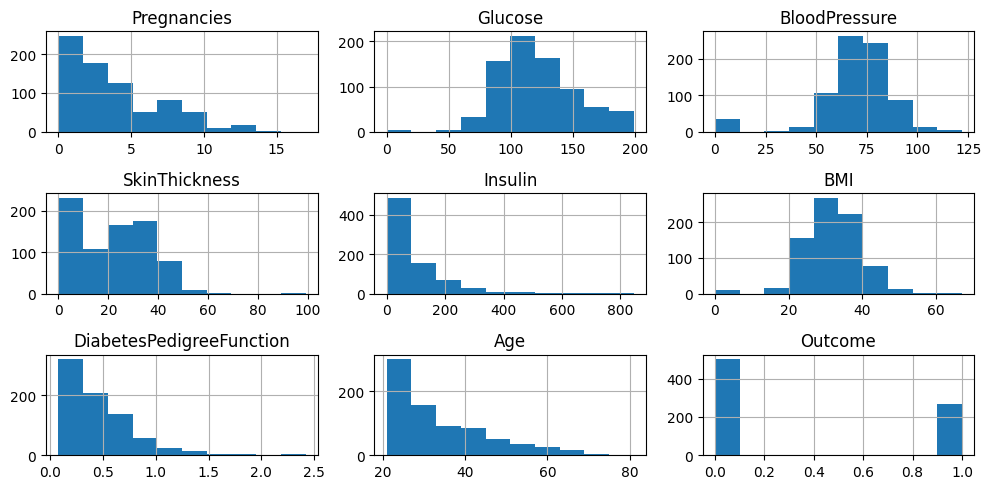

In [14]:
# Histograms
df.hist(figsize=(10, 5))
plt.tight_layout()
plt.show()

Here are the observations for the relevant columns:

*   Glucose: Normally Distributed
*   Blood Pressure: Normally Distributed
*   Skin Thickness: Skewed to the right
*   Insulin: Skewed to the right
*   BMI: Seems to be normally distributed

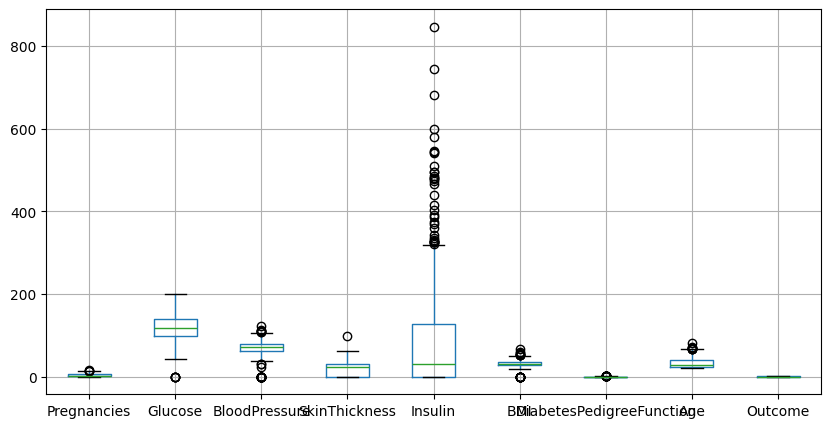

In [15]:
# Box plots
plt.figure(figsize=(10, 5))
df.boxplot()
plt.show()

Here are the observations for the relevant columns:

*   Glucose: A nearly-zero amount of outliers
*   Blood Pressure: A decent amount of outliers
*   Skin Thickness: A small amount of outliers
*   Insulin: A huge amount of outliers
*   BMI: A medium amount of outliers

We will not impute the columns' missing data with the relevant methods

In [16]:
# Replace 0 values with NaN for specific columns
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[columns_to_impute] = df[columns_to_impute].replace(0, np.nan)

# Impute missing values with either median or mean for each column
df['Glucose'].fillna(df['Glucose'].mean(), inplace=True)
df['BloodPressure'].fillna(df['BloodPressure'].mean(), inplace=True)
df['SkinThickness'].fillna(df['SkinThickness'].median(), inplace = True)
df['Insulin'].fillna(df['Insulin'].median(), inplace = True)
df['BMI'].fillna(df['BMI'].median(), inplace = True)

# Double Check that we don't have any more nulls
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


## Exploratory Data Analysis

Let's explore the data to find imporant trends and features.

### Basic Statistics and Overview

In [17]:
# Basic description of the dataframe
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


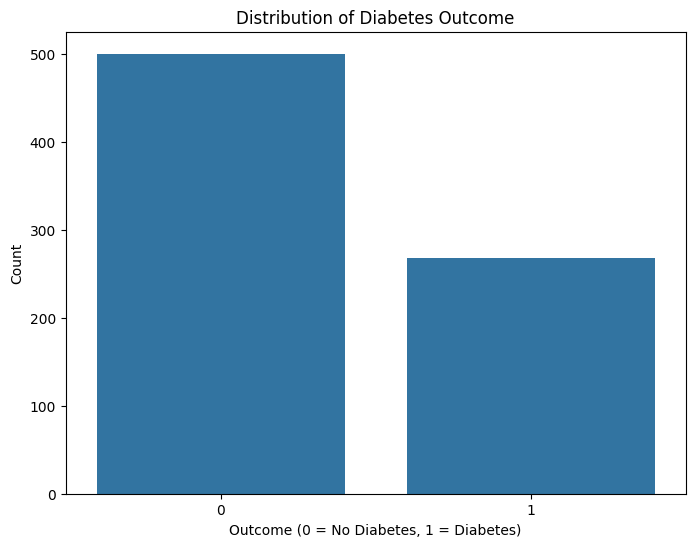

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Diabetes Outcome')
plt.xlabel('Outcome (0 = No Diabetes, 1 = Diabetes)')
plt.ylabel('Count')
plt.show()

### Data Visualization

Let's take a look at some basic plots to understand what features appear more frequently to people with diabetes.


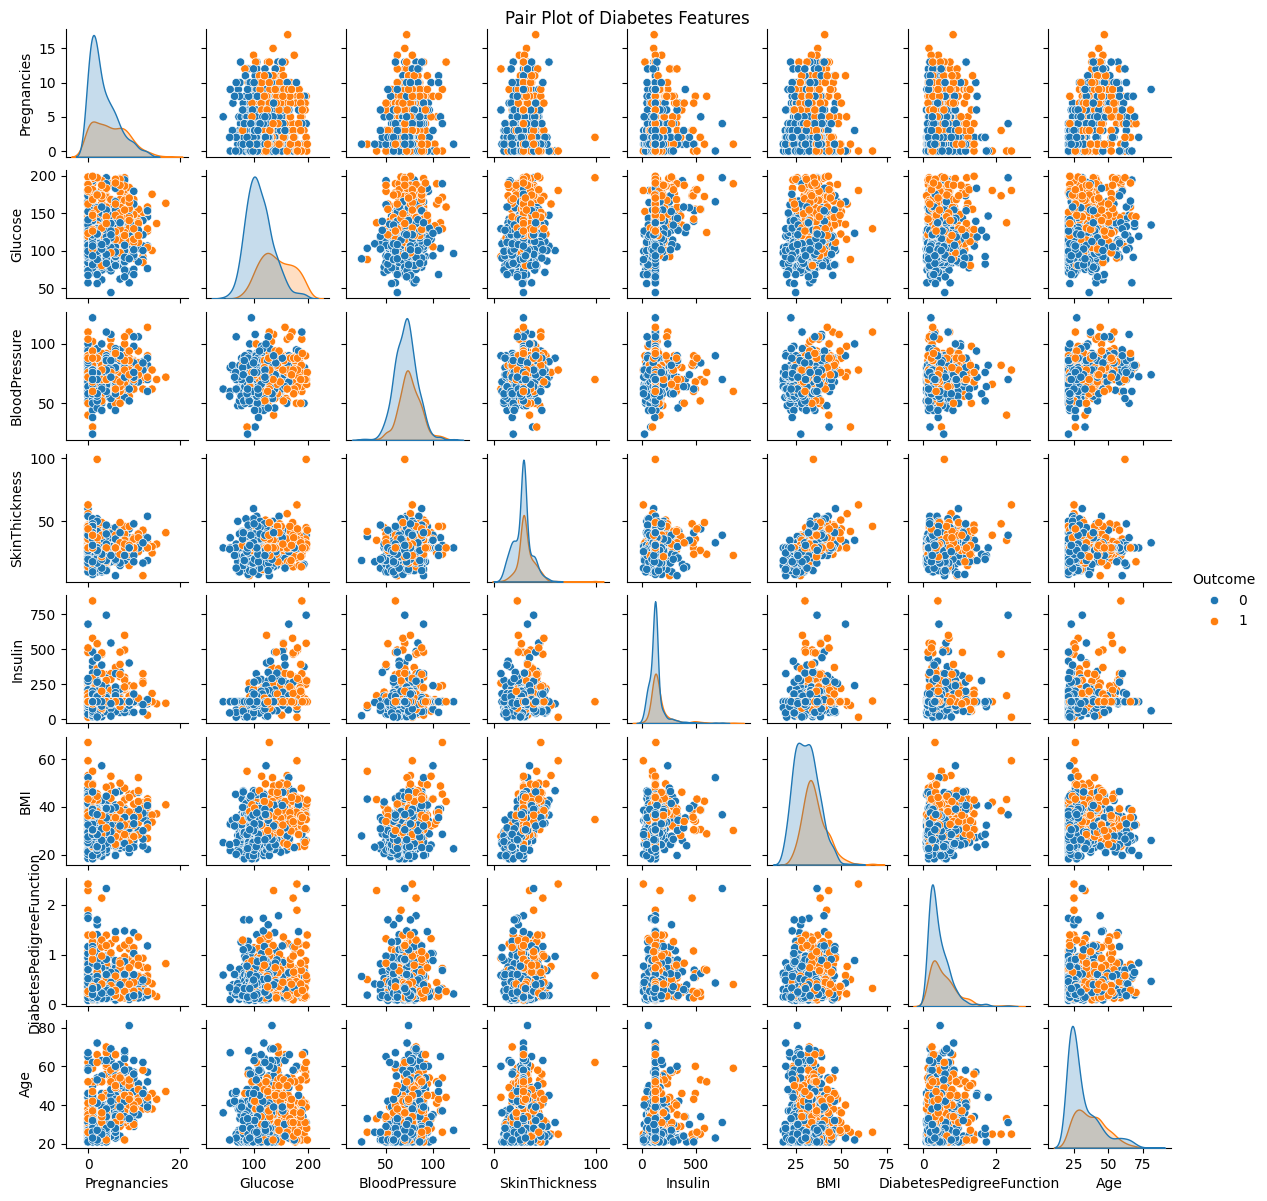

In [19]:
# Pairplot
sns.pairplot(df, hue='Outcome', diag_kind='kde', height=1.5)
plt.suptitle('Pair Plot of Diabetes Features', y=1)
plt.show()

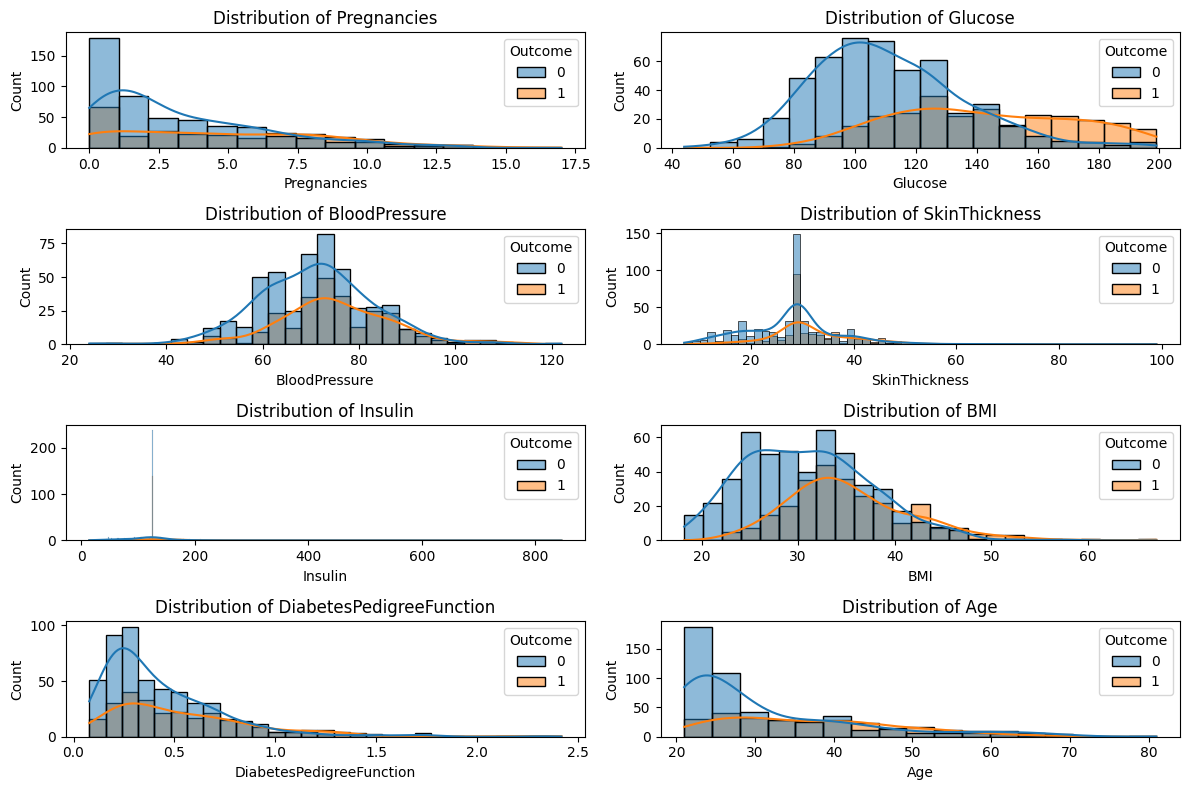

In [20]:
# Histogram
fig, axes = plt.subplots(4, 2, figsize=(12, 8))
axes = axes.flatten()

for i, column in enumerate(df.columns[:-1]):
    sns.histplot(data=df, x=column, hue='Outcome', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

There's a massive spike in insulin, so we'll take a closer look at it and apply a logarithmic transformation

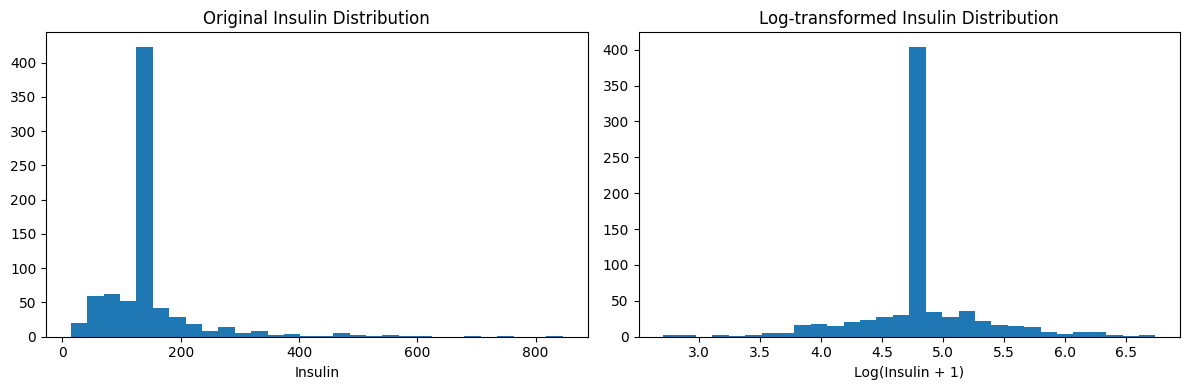

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(df['Insulin'], bins=30)
plt.title('Original Insulin Distribution')
plt.xlabel('Insulin')

plt.subplot(122)
plt.hist(np.log1p(df['Insulin']), bins=30)
plt.title('Log-transformed Insulin Distribution')
plt.xlabel('Log(Insulin + 1)')

plt.tight_layout()
plt.show()

### Correlation Analysis

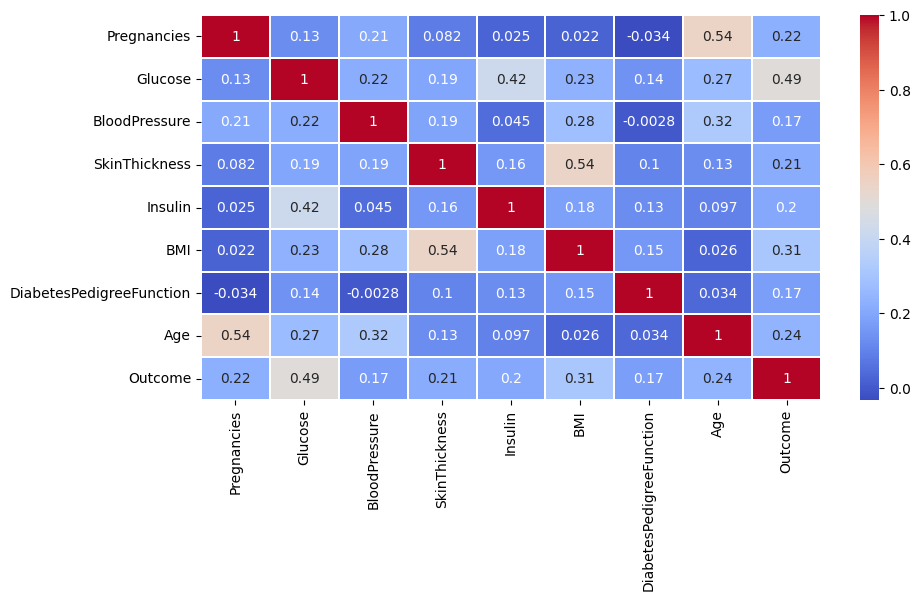

In [22]:
# Correlation heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),
            annot = True,
            cmap = 'coolwarm',
            linewidths= .1)
plt.show()

Top features that affect the outcome seem to be:
* Glucose
* BMI
* Age
* Pregnancies


## Data Preprocessing

Let's preprocess the data.

### Feature Engineering

BMI Categories: We'll see what BMI groups are suspect do diabetes

In [23]:
def bmi_category(bmi):
    if bmi < 18.5:
        return 0  # Underweight
    elif 18.5 <= bmi < 25:
        return 1  # Normal weight
    elif 25 <= bmi < 30:
        return 2  # Overweight
    else:
        return 3  # Obese

df['BMI_Category'] = df['BMI'].apply(bmi_category)
print(df['BMI_Category'].value_counts())

BMI_Category
3    483
2    179
1    102
0      4
Name: count, dtype: int64


Agr Groups: We can create age groups to capture potential relationships between age and diabetes risk:

In [24]:
def age_group(age):
    if age < 30:
        return 0  # Young adult
    elif 30 <= age < 45:
        return 1  # Adult
    elif 45 <= age < 60:
        return 2  # Middle-aged
    else:
        return 3  # Senior

df['Age_Group'] = df['Age'].apply(age_group)
print(df['Age_Group'].value_counts())

Age_Group
0    396
1    239
2    101
3     32
Name: count, dtype: int64


Glucose-to-Insulin Ratio: This ratio can provide insights into insulin sensitivity:

In [25]:
df['Glucose_Insulin_Ratio'] = df['Glucose'] / (df['Insulin'] + 1)  # Adding 1 to avoid division by zero
print(df['Glucose_Insulin_Ratio'].describe())

count    768.000000
mean       1.054897
std        0.685862
min        0.206323
25%        0.746032
50%        0.943222
75%        1.175893
max       12.000000
Name: Glucose_Insulin_Ratio, dtype: float64


Pregnancy Risk Factor: Women with more pregnancies may have a higher risk of gestational diabetes:

In [26]:
def pregnancy_risk(pregnancies):
    if pregnancies == 0:
        return 0  # No pregnancies
    elif pregnancies <= 2:
        return 1  # Low risk
    elif pregnancies <= 4:
        return 2  # Medium risk
    elif pregnancies > 4:
        return 3  # High risk

df['Pregnancy_Risk'] = df['Pregnancies'].apply(pregnancy_risk)
print(df['Pregnancy_Risk'].value_counts())

Pregnancy_Risk
3    276
1    238
2    143
0    111
Name: count, dtype: int64


Let's examine the categorical columns.

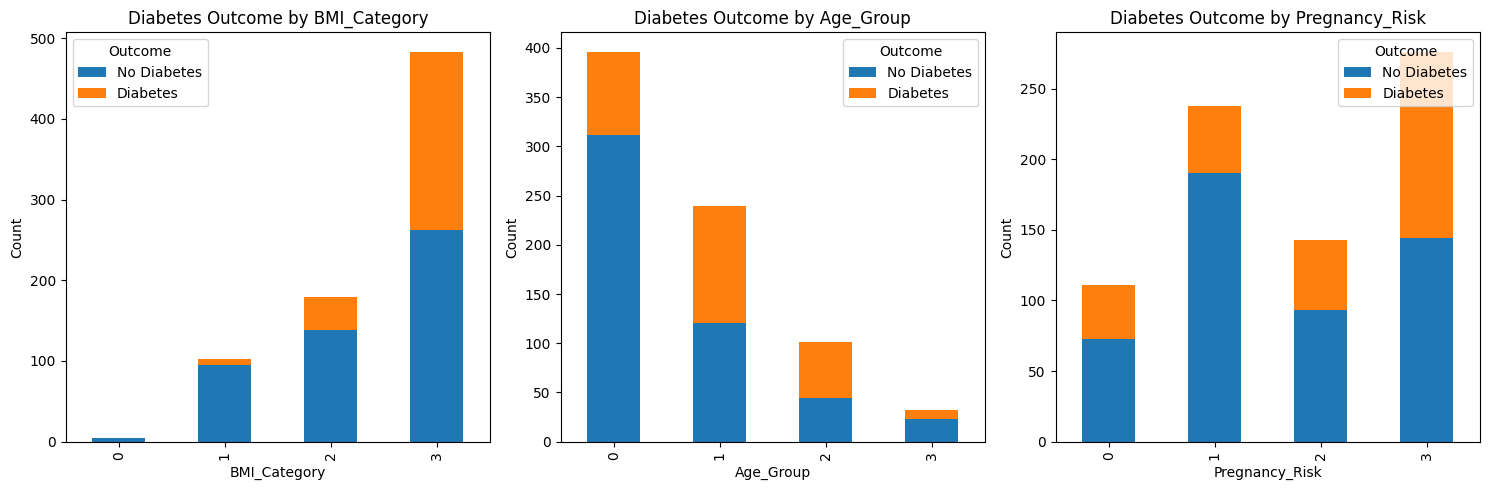

In [27]:
categorical_cols = ['BMI_Category', 'Age_Group', 'Pregnancy_Risk']

# Create subplots for each category
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(15, 5))

for i, col in enumerate(categorical_cols):
    outcome_counts = df.groupby(col)['Outcome'].value_counts().unstack(fill_value=0)

    # Plot the counts
    outcome_counts.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'Diabetes Outcome by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Outcome', labels=['No Diabetes', 'Diabetes'])

plt.tight_layout()
plt.show()

### Imbalanced classes


In [28]:
class_distribution = df['Outcome'].value_counts(normalize=True)
print(class_distribution)

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


We might need to undersample and oversample the data, seeing this balance. When I originally made this project, there were too many false negatives in the model's results.

In [29]:
# Replace zeros with median values
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    df[column] = df[column].replace(0, df[df[column] != 0][column].median())

### Splitting data into train, validation, and test sets

In [30]:
# Select features and target
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X = df[features]
y = df['Outcome']

# Testing, training, and splitting the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

###Feature scaling

In [31]:
# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),
                              columns=X_train.columns,
                              index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                             columns=X_test.columns,
                             index=X_test.index)

Let's take a quick look at the scaled dataframe.

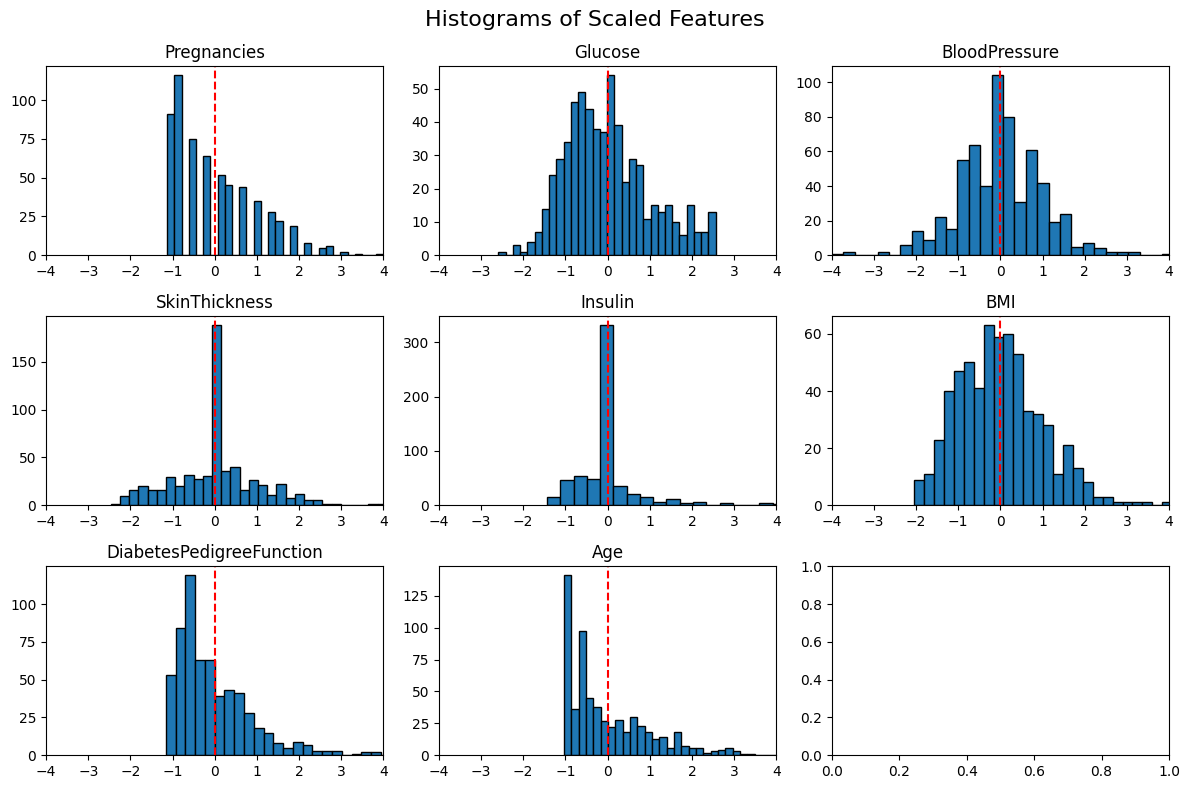

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
fig.suptitle('Histograms of Scaled Features', fontsize=16)

for i, column in enumerate(X_train_scaled.columns):
    row = i // 3
    col = i % 3
    axes[row, col].hist(X_train_scaled[column],
                        bins=30,
                        edgecolor='black')
    axes[row, col].set_title(column)
    axes[row, col].axvline(x=0, color='r', linestyle='--')
    axes[row, col].set_xlim(-4, 4)

plt.tight_layout()
plt.show()

In [33]:
print(X_train_scaled.min())
print(X_train_scaled.max())

Pregnancies                -1.130523
Glucose                    -2.588180
BloodPressure              -3.990734
SkinThickness              -2.464199
Insulin                    -1.435135
BMI                        -2.042121
DiabetesPedigreeFunction   -1.162210
Age                        -1.035940
dtype: float64
Pregnancies                 4.004552
Glucose                     2.565174
BloodPressure               4.115558
SkinThickness               4.079483
Insulin                     8.005558
BMI                         5.014290
DiabetesPedigreeFunction    5.796175
Age                         4.184145
dtype: float64


## Unsupervised Learning

### Dimensionality reduction using PCA
Principal Component Analysis (PCA) can help us reduce the dimensionality of our dataset while preserving as much variance as possible.

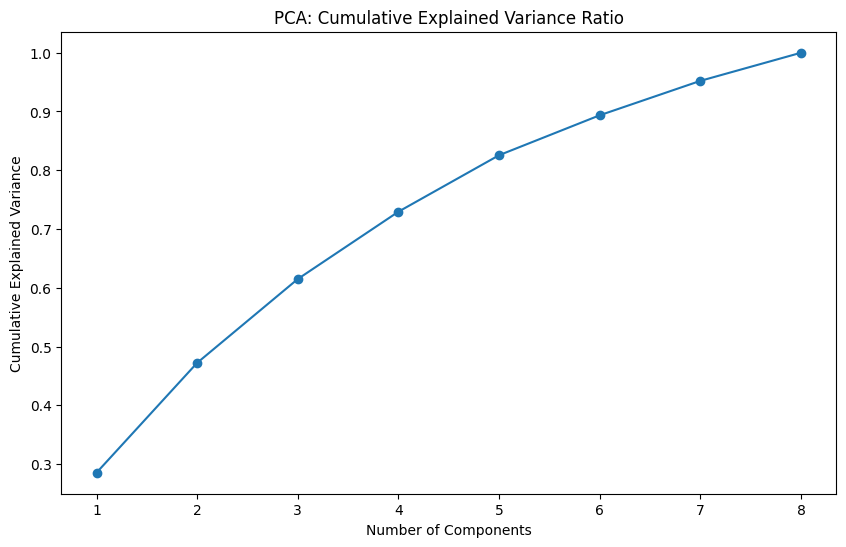

In [34]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot the variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, 9), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance Ratio')
plt.show()


- The first component captures about 28% of the variance
- By 4 components, approximately 73% of the variance is explained
- Adding more components yields diminishing returns
- Eight components capture 100% of the variance

### Clustering analysis using K-means
K-means clustering can help us identify potential subgroups within our data.

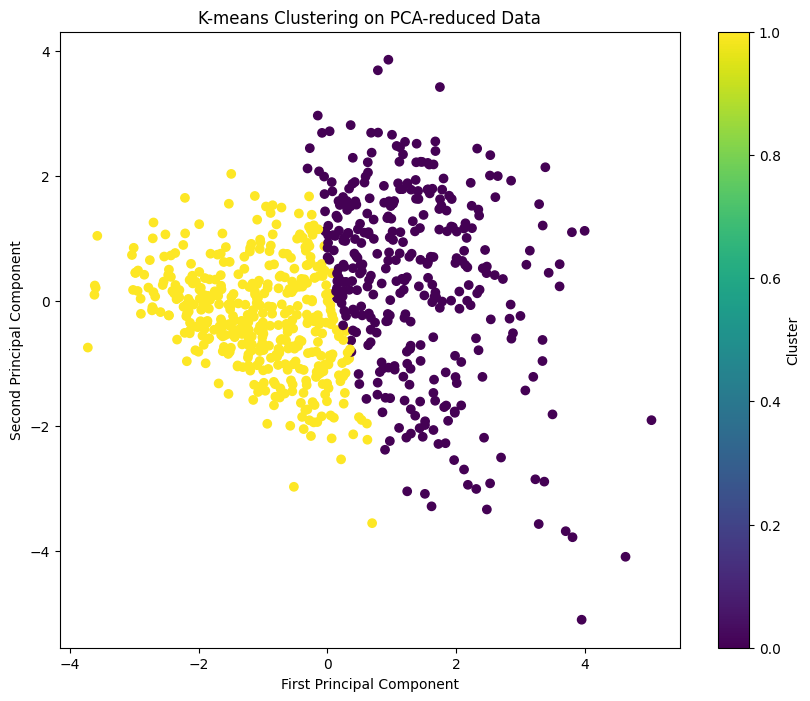

In [35]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Visualize the clusters using the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-means Clustering on PCA-reduced Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Cluster')
plt.show()

- Two distinct clusters are visible, represented by purple and yellow points
- The clusters show clear separation, particularly along the first principal component
- The data spans roughly from -4 to 4 on both axes
- There is some overlap between clusters near the center (around 0,0)

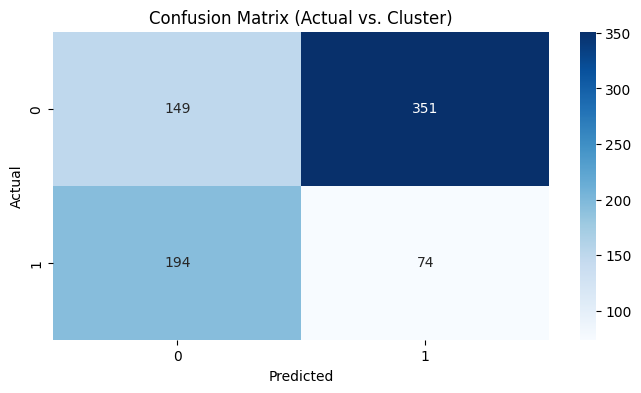

In [36]:
# Confusion matrix
cm = confusion_matrix(y, cluster_labels)

# Create a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Actual vs. Cluster)')

# Show the plot
plt.show()

These are fairly bad numbers, we want there to be less False negatives and positives

## Supervised Learning

### Logistic Regression
Logistic regression is a good baseline model for binary classification problems like diabetes prediction. It's simple, interpretable, and often performs well on linearly separable data.

In [37]:
# Train logistic regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print("Logistic Regression Performance:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-score: {lr_f1:.4f}")

Logistic Regression Performance:
Accuracy: 0.7727
Precision: 0.6923
Recall: 0.6545
F1-score: 0.6729


### Neural Network
For the neural network, we'll use a simple feedforward architecture with multiple hidden layers. This allows the model to capture non-linear relationships in the data.

In [38]:
# Define the model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=0)

# Make predictions
y_pred_nn = (model.predict(X_test) > 0.5).astype(int)

# Evaluate performance
nn_accuracy = accuracy_score(y_test, y_pred_nn)
nn_precision = precision_score(y_test, y_pred_nn)
nn_recall = recall_score(y_test, y_pred_nn)
nn_f1 = f1_score(y_test, y_pred_nn)

print("Neural Network Performance:")
print(f"Accuracy: {nn_accuracy:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall: {nn_recall:.4f}")
print(f"F1-score: {nn_f1:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Neural Network Performance:
Accuracy: 0.6818
Precision: 0.6000
Recall: 0.3273
F1-score: 0.4235


## Results and Evaluation

### Model performance comparison

In [39]:
models = ['Logistic Regression', 'Neural Network']
accuracies = [lr_accuracy, nn_accuracy]
precisions = [lr_precision, nn_precision]
recalls = [lr_recall, nn_recall]
f1_scores = [lr_f1, nn_f1]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-score': f1_scores
})

print(comparison_df)

                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.772727   0.692308  0.654545  0.672897
1       Neural Network  0.681818   0.600000  0.327273  0.423529


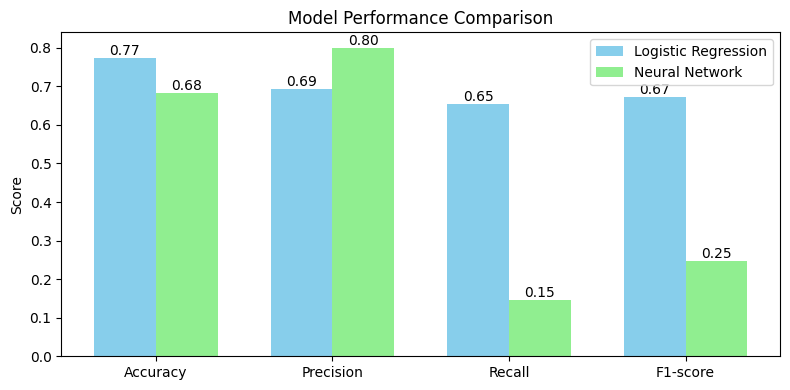

In [40]:
# Prepare the data
models = ['Logistic Regression', 'Neural Network']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = np.array([[0.772727, 0.692308, 0.654545, 0.672897],
                   [0.681818, 0.800000, 0.145455, 0.246154]])


# Set up the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Set the width of each bar and positions of the bars
width = 0.35
x = np.arange(len(metrics))

# Create the bars
ax.bar(x - width/2, values[0], width, label='Logistic Regression', color='skyblue')
ax.bar(x + width/2, values[1], width, label='Neural Network', color='lightgreen')

# Customize the plot
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on top of each bar
for i in range(len(x)):
    for j in range(len(models)):
        ax.text(i + (j-0.5)*width, values[j][i], f'{values[j][i]:.2f}',
                ha='center', va='bottom')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Accuracy: The Logistic Regression method was more accurate, meaning it had better overall correct predictions.

Precision: The neural network model had a better proportion of correct positive predictions out of all positive predictions made

Recall: Logistic Regression far outclasses neural network when it came to recall, it had a better ability to find positive instances

F1-score: The F1 score for Logistic Regression won out, but it can be fair to say that the sample was fairly uneven thus resulting in a low F1-score

### Visualization of results


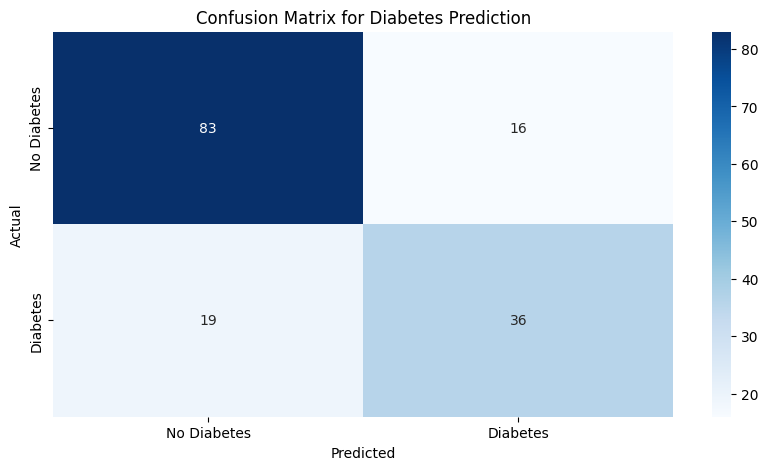

In [41]:
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix for Diabetes Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

These numbers are better, we have less falose positives and negatives

Let's check which feature was most important

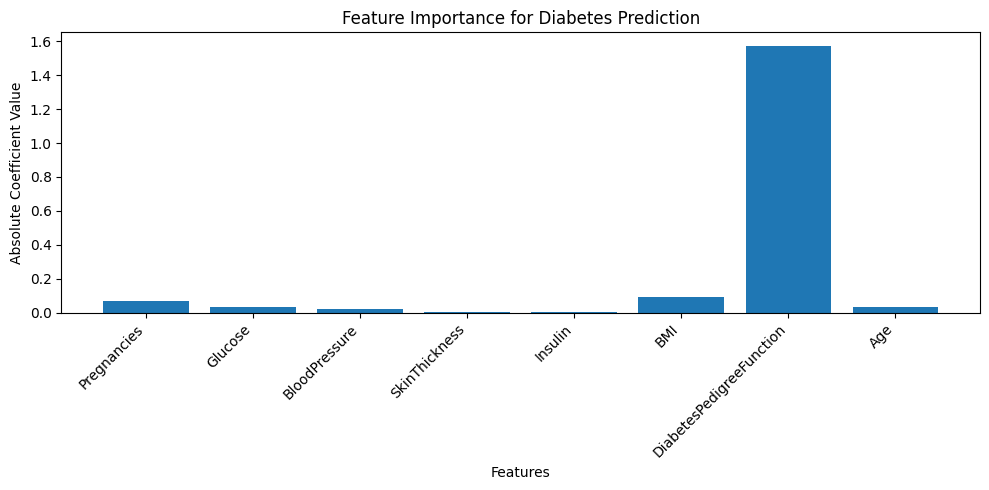

In [42]:
feature_importance = np.abs(model.coef_[0])
feature_names = X.columns

plt.figure(figsize=(10, 5))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance for Diabetes Prediction')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

It seems that the number one factor that affects Diabetes is the Diabetes Pedgree Function. This is a function that scores the probability of diabetes based on family history

Let's remove Diabetes Pedigree Function so we can see the other variables better.

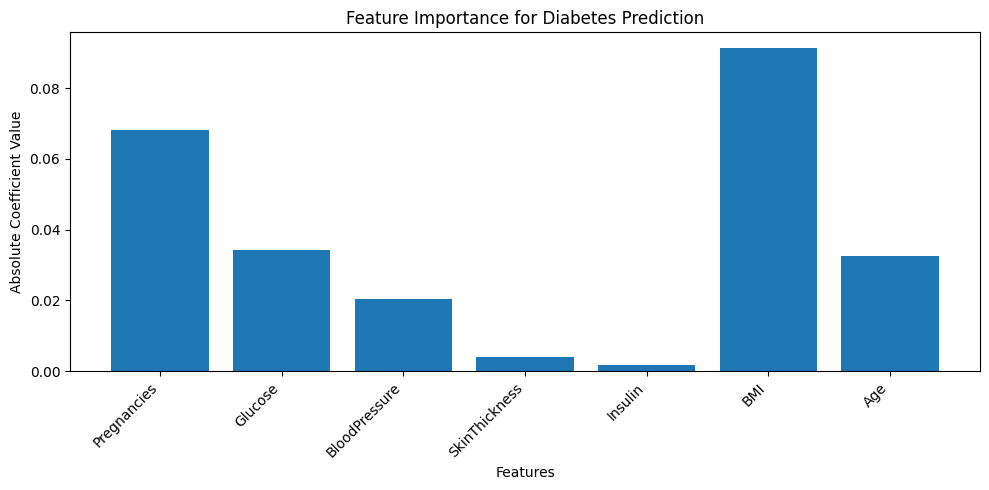

In [43]:
# Remove 'DiabetesPedigreeFunction' from feature names and importance
mask = feature_names != 'DiabetesPedigreeFunction'
feature_names = feature_names[mask]
feature_importance = feature_importance[mask]

plt.figure(figsize=(10, 5))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance for Diabetes Prediction')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- BMI        : It seems that people on a higher BMI tend to test positive
- Pregnancies: Gestational diabetes is the term here
- Age        : Older people tend to be more susceptible
- Glucose    : This one might be more of a correlation than causation

## Conclusion

### Key Findings:


Here are the top 5 most important features:
- DiabetesPedgreeFunction
- BMI
- Pregnancies
- Age
- Glucose

This is contrasted by the earlier correlation map that assumed this was the order:
- Glucose
- BMI
- Age
- Pregnancies

The better overall model was logistic regression. There seemed to be an imbalance in the results.

### Limitations:
Both models could easily be improved, they're ability to detect positive cases was bad. The models cannot be used as a standalone tool and either need to be fixed or supplemented.

### Future Work:
- Explore more advanced models or ensemble methods to improve accuracy.
- Address the class imbalance through techniques like oversampling or undersampling.
- Conduct feature engineering to potentially improve the model's performance.
- Collect more data, especially for the diabetic class, to balance the dataset and potentially improve predictive power.
- Investigate the impact of zero values in certain features and develop more sophisticated imputation techniques.
- Evaluate the model's performance on external datasets to assess its generalizability.

Thank you for taking the time to read this project, I will bring improvements in the future. Until then, keep mining and analyzing.

## Source
Pima Indians Diabetes Database by UCI Machine Learning Repository
